In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
species_labels=pd.read_csv('species_labels.csv')
species_labels

,Unnamed: 0,category_id,species,season,datetime,count,image_id
0,0,0,empty,S1,2010-08-02 11:43:14,0,S1/B04/B04_R1/S1_B04_R1_PICT0014.JPG
1,1,0,empty,S1,2010-07-20 15:23:10,0,S1/B05/B05_R1/S1_B05_R1_PICT0004.JPG
2,2,0,empty,S1,2010-07-21 14:34:02,0,S1/B05/B05_R1/S1_B05_R1_PICT0008.JPG
3,3,0,empty,S1,2010-08-03 01:06:08,0,S1/B05/B05_R1/S1_B05_R1_PICT0050.JPG
4,4,0,empty,S1,2010-08-10 17:58:00,0,S1/B05/B05_R1/S1_B05_R1_PICT0074.JPG
...,...,...,...,...,...,...,...
488563,488563,48,reptiles,S1,2010-09-23 11:56:36,1,S1/U13/U13_R1/S1_U13_R1_PICT0084.JPG
488564,488564,48,reptiles,S1,2010-09-23 11:56:36,1,S1/U13/U13_R1/S1_U13_R1_PICT0085.JPG
488565,488565,48,reptiles,S1,2010-10-01 13:40:06,2,S1/U13/U13_R1/S1_U13_R1_PICT0359.JPG
488566,488566,48,reptiles,S1,2010-10-01 13:40:06,2,S1/U13/U13_R1/S1_U13_R1_PICT0360.JPG


In [2]:
from fastai.vision.all import *

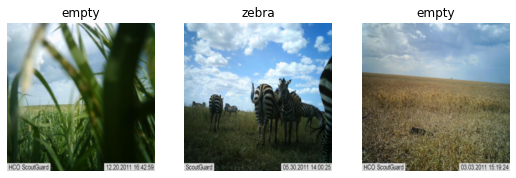

In [3]:
def get_x(r): return r['image_id']
def get_y(r): return r['species']
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = Resize(256, ResizeMethod.Squish))

dls = dblock.dataloaders(species_labels,bs=16)
dls.show_batch(nrows=1,ncols=3)

In [4]:
fscore = FBeta(average='macro', beta=1)
learn = cnn_learner(dls, resnet50, metrics=[accuracy, fscore, error_rate])

In [5]:
learn.load('stage_3_try_2')

In [8]:
#Code from fastai forums to fix memory efficency issue with interpretation
class Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, preds, targs, decoded, losses): store_attr()

    def __getitem__(self, idxs):
        "Get the the inputs, preds, targs, decoded outputs, and losses at `idxs`"
        if isinstance(idxs, Tensor): idxs = idxs.tolist()
        if not is_listy(idxs): idxs = [idxs]
        attrs = 'preds,targs,decoded,losses'
        res = L([getattr(self, attr)[idxs] for attr in attrs.split(',')])
        inps = [self.dl.do_item(o)[:self.dl.n_inp] for o in idxs]
        inps = self.dl.after_batch(to_device(self.dl.do_batch(inps), self.dl.device))
        return inps + res

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from a learner"
        if dl is None: dl = learn.dls[ds_idx]
        return cls(dl, *learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=True, act=None))

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)

    def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        inps, preds, targs, decoded, _ = self[idx]
        if not isinstance(inps, tuple): inps = (inps,)
        b = inps + (targs,)
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + (decoded,)
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), preds, losses,  **kwargs)

In [9]:
interp = Interpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

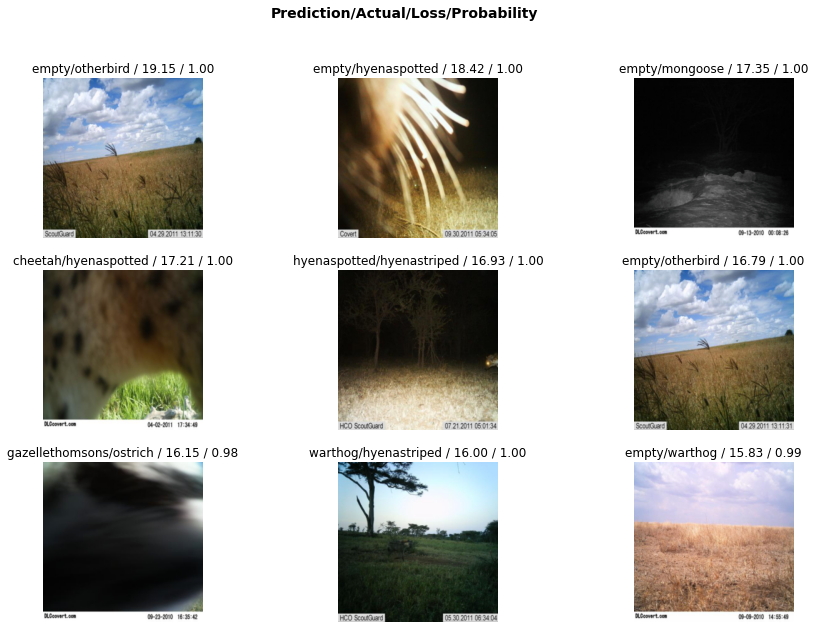

In [10]:
interp.plot_top_losses(9, figsize=(15,10))
plt.savefig('stage_3_top_losses.png')

In [ ]:
learn.export()

In [11]:
path=Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [12]:
learn_inf = load_learner(path/'export.pkl')

In [13]:
learn_inf.predict('S4/B10/B10_R1/S4_B10_R1_IMAG0029.JPG')

('impala',
 tensor(24),
 tensor([7.5841e-09, 3.6750e-07, 2.4430e-07, 1.9324e-09, 1.7936e-08, 1.0582e-07,
         8.4289e-09, 3.6204e-08, 1.3825e-07, 1.5401e-09, 1.5712e-09, 8.5345e-11,
         1.8744e-08, 6.7453e-07, 1.8283e-08, 1.1300e-07, 1.0321e-07, 9.5773e-09,
         2.1283e-08, 5.6842e-06, 3.6067e-07, 3.8624e-08, 7.5710e-10, 9.1839e-08,
         9.9998e-01, 9.1133e-09, 1.7157e-08, 5.0764e-08, 1.2187e-09, 1.8228e-08,
         2.0807e-08, 1.1620e-07, 2.7042e-08, 1.0719e-08, 1.7190e-07, 3.2859e-07,
         1.1690e-07, 4.4370e-08, 2.1689e-07, 2.6033e-08, 7.0960e-07, 2.1282e-07,
         2.4350e-09, 6.0634e-07, 8.8351e-08, 1.6952e-07, 4.5287e-06, 1.0430e-07]))

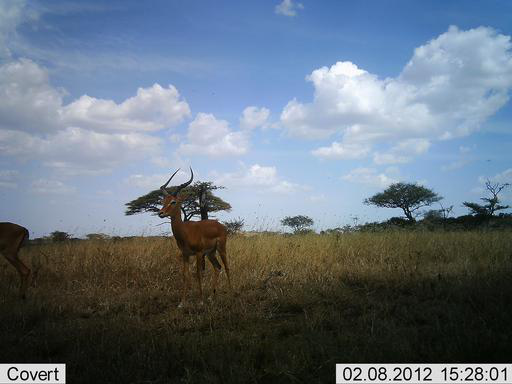

In [14]:
from PIL import Image
im=Image.open('S4/B10/B10_R1/S4_B10_R1_IMAG0029.JPG','r')
im

In [15]:
test=pd.read_csv('test.csv')
test.loc[test['image_id'] == 'S4/B10/B10_R1/S4_B10_R1_IMAG0029.JPG']

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,category_id,species,season,datetime,count,image_id
425846,425846,10,impala,S4,2012-02-08 15:28:10,2,S4/B10/B10_R1/S4_B10_R1_IMAG0029.JPG


In [16]:
learn_inf.predict('S4/U13/U13_R2/S4_U13_R2_IMAG3819.JPG')

('zebra',
 tensor(46),
 tensor([1.4815e-05, 3.0497e-05, 1.1086e-05, 1.1251e-05, 1.6338e-05, 6.3770e-06,
         5.4261e-06, 7.6681e-06, 8.4900e-06, 3.3176e-05, 5.6148e-05, 2.0024e-06,
         5.5313e-05, 1.3312e-03, 1.4305e-04, 7.1088e-06, 5.1283e-05, 1.2290e-04,
         8.5808e-06, 1.6140e-05, 7.1548e-06, 5.7920e-06, 9.0294e-05, 2.7972e-05,
         5.4496e-05, 1.4342e-05, 3.2667e-05, 1.3407e-05, 1.4079e-05, 1.6244e-06,
         5.5436e-06, 4.0518e-05, 1.8847e-06, 2.6967e-04, 4.9981e-06, 8.2924e-06,
         9.9870e-06, 5.1630e-06, 4.4747e-06, 1.4391e-05, 2.4513e-05, 2.6203e-05,
         1.8615e-04, 1.8993e-06, 6.7660e-06, 9.7765e-03, 9.8741e-01, 5.0703e-06]))

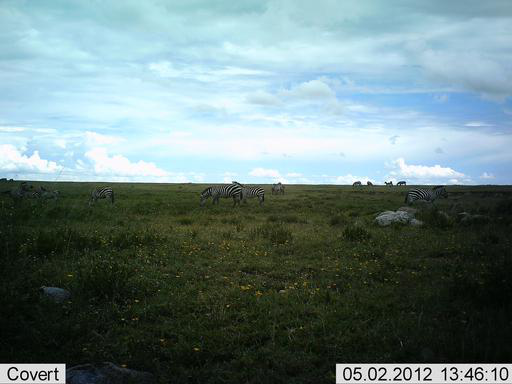

In [17]:
im=Image.open('S4/U13/U13_R2/S4_U13_R2_IMAG3819.JPG','r')
im

In [18]:
test.loc[test['image_id'] == 'S4/U13/U13_R2/S4_U13_R2_IMAG3819.JPG']

,Unnamed: 0,category_id,species,season,datetime,count,image_id
410042,410042,5,zebra,S4,2012-05-02 13:46:19,11-50,S4/U13/U13_R2/S4_U13_R2_IMAG3819.JPG
